## Installations and Imports :



In [ ]:
!pip install sklearn librosa mir_eval tensorflow

In [ ]:
#!/usr/bin/env python3
import argparse

from numpy.lib.npyio import save
from Models import MLP, MLP_scalered, CRNN, CRNN_1, MLP2RNN, CRNN_2, BassVsThird
from Datasets import IsophonicsDataset 
import sklearn
import sys

In [ ]:
#!/usr/bin/env python3
parser = argparse.ArgumentParser()
# Directories, destinations, folders, files
parser.add_argument("--isophonics_audio_directory", default="./Datasets/Isophonics/AUDIO", type=str, help="Path to ISOPHONICS directory with audio files.")
parser.add_argument("--isophonics_annotations_directory", default="./Datasets/Isophonics/ANNOTATIONS", type=str, help="Path to ISOPHONICS directory with chord annotations.")
parser.add_argument("--billboard_audio_directory", default="./Datasets/Billboard/AUDIO", type=str, help="Path to BILLBOARD directory with audio files.")
parser.add_argument("--billboard_annotations_directory", default="./Datasets/Billboard/ANNOTATIONS", type=str, help="Path to BILLBOARD directory with chord annotations.")
parser.add_argument("--isophonics_prep_dest", default="./PreprocessedDatasets/isophonics_new.ds", type=str, help="Preprocessed ISOPHONICS dataset destination.")
parser.add_argument("--billboard_prep_dest", default="./PreprocessedDatasets/billboard_new.ds", type=str, help="Preprocessed BILLBOARD dataset destination.")

# Dataset preprocessing args
parser.add_argument("--dataset", default="isophonics", type=str, help="Dataset we want to preprocess, {isophonics, billboard}")
#           Isophonics
parser.add_argument("--sample_rate", default=44100, type=int, help="Sample rate for each song.")
parser.add_argument("--hop_length", default=512, type=int, help="10*(sample_rate/hop_length) is a number of miliseconds between two frames.")
parser.add_argument("--window_size", default=8, type=int, help="Spectrograms on left, and also spectrogram on right of the time bin -> window_size*2 + 1 spectrograms grouped together.")
parser.add_argument("--flattened_window", default=False, type=bool, help="Whether the spectrogram window should be flatten to one array or it sould be array of spectrograms.")
parser.add_argument("--ms_intervals", default=430.6640625, type=float, help="Miliseconds between generated spectrograms.")
parser.add_argument("--to_skip", default=10, type=int, help="How many spectrogram we want to skip when creating spectrogram window.")
parser.add_argument("--norm_to_C", default=True, type=bool, help="Whether we want to transpose all songs to C key (or D dorian, .. A minor, ...)")
parser.add_argument("--spectrogram_type", default="cqt", type=str, help="Spectrogram types, {cqt,log_mel}")
#           Billboard
parser.add_argument("--n_frames", default=1000, type=int, help="Length of song subsequence we are consinder when predicting chords to keep some context.")

# Training args
parser.add_argument("--test_size", default=0.3, type=lambda x:int(x) if x.isdigit() else float(x), help="Test set size.")
parser.add_argument("--epochs", default=100, type=int, help="Number of epochs.")
parser.add_argument("--seed", default=42, type=int, help="Random seed.")


args = parser.parse_args([] if "__file__" not in globals() else None)

# ISOPHONICS DATASET 
*STFT length is by default 2^14 = 16384*

## MLP with scaler preprocessing (and all songs in C major key)

### MLP with scaler preprocessing, mel log - *50.68% (56.77% with another sample rate)*

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The MLP model with scaler preprocessing was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  56.77 % 



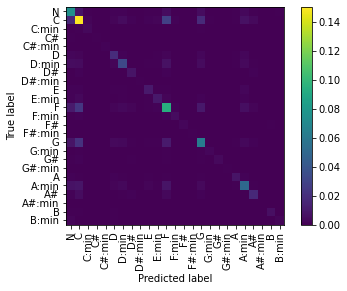

In [ ]:
#!/usr/bin/env python3
# hop length 11008, sample rate 22050, flattened, window size 5, normalized to C major, skip 1
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_22050_11008_5_flattened_mel_log_1skip.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP_scalered(random_state=7)

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The MLP model with scaler preprocessing was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  50.68 % 



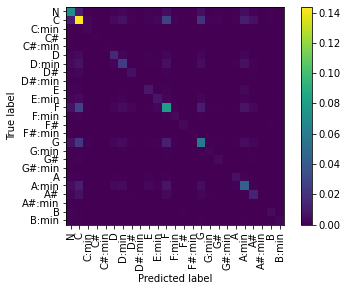

In [ ]:
#!/usr/bin/env python3
# hop length 22050, sample rate 44100, flattened, window size 5, normalized to C major, skip 1
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_5_true_500_1_true.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP_scalered(random_state=7)

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

## CRNN model
*sample rate 22050, hop_length 512, 1000 frames*

### *shifted CQT - 68.12%*

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 252, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 252, 16)     64        
______________________________________________________

Epoch 31/75
40/40 [==============================] - 22s 539ms/step - loss: 0.3169 - accuracy: 0.9026 - val_loss: 1.1944 - val_accuracy: 0.6661
Epoch 32/75
40/40 [==============================] - 21s 539ms/step - loss: 0.2845 - accuracy: 0.9122 - val_loss: 1.2112 - val_accuracy: 0.6569
Epoch 33/75
40/40 [==============================] - 22s 539ms/step - loss: 0.2645 - accuracy: 0.9195 - val_loss: 1.2178 - val_accuracy: 0.6660
Epoch 34/75
40/40 [==============================] - 21s 539ms/step - loss: 0.2411 - accuracy: 0.9268 - val_loss: 1.2136 - val_accuracy: 0.6694
Epoch 35/75
40/40 [==============================] - 22s 542ms/step - loss: 0.2307 - accuracy: 0.9309 - val_loss: 1.2414 - val_accuracy: 0.6645
Epoch 36/75
40/40 [==============================] - 22s 540ms/step - loss: 0.2081 - accuracy: 0.9374 - val_loss: 1.2404 - val_accuracy: 0.6697
Epoch 37/75
40/40 [==============================] - 22s 542ms/step - loss: 0.1857 - accuracy: 0.9448 - val_loss: 1.2491 - val_accuracy:

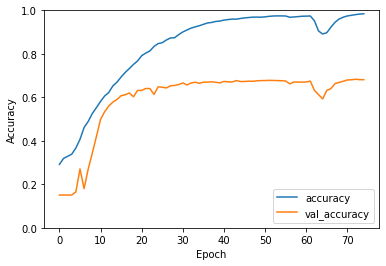

17/17 - 2s - loss: 1.4805 - accuracy: 0.6812

 Dev accuracy:  68.12 % 



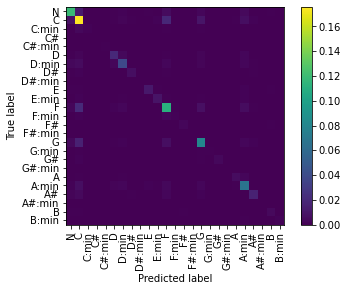

In [ ]:
#!/usr/bin/env python3
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("../input/acrisophonics2/Isophonics1000.ds")
n_samples, n_frames, n_chromas = x.shape
x = x.reshape((n_samples,n_frames,n_chromas,1))
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=0.3, random_state=args.seed)
 
# Create model
crnn_model = CRNN_1(input_shape=(n_frames, n_chromas, 1), output_classes=25)
 
# Train model
crnn_model.fit(train_x, train_y, dev_x, dev_y, epochs=75)
 
# Display score
crnn_model.display_training_progress()
print("\n","Dev accuracy: ", "{:.2f}".format(100*crnn_model.score(dev_x, dev_y)), "%", "\n")
crnn_model.display_confusion_matrix(dev_x, dev_y)

### *not shifted CQT - 65.35%* 

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 252, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 252, 16)     64        
______________________________________________________

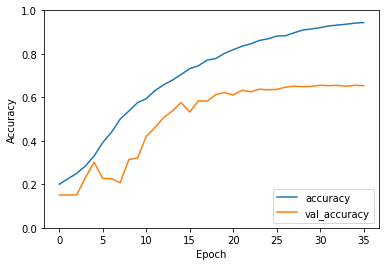

17/17 - 91s - loss: 1.2689 - accuracy: 0.6535

 Dev accuracy:  65.35 % 



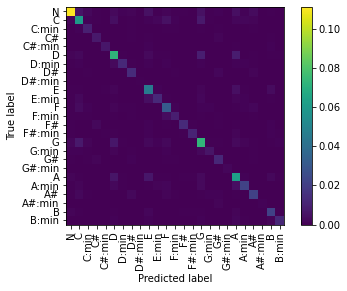

In [ ]:
#!/usr/bin/env python3
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./drive/MyDrive/Isophonics1000.ds")
n_samples, n_frames, n_chromas = x.shape
x = x.reshape((n_samples,n_frames,n_chromas,1))
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=0.3, random_state=args.seed)
 
# Create model
crnn_model = CRNN_1(input_shape=(n_frames, n_chromas, 1), output_classes=25)
 
# Train model
crnn_model.fit(train_x, train_y, dev_x, dev_y, epochs=36)
 
# Display score
crnn_model.display_training_progress()
print("\n","Dev accuracy: ", "{:.2f}".format(100*crnn_model.score(dev_x, dev_y)), "%", "\n")
crnn_model.display_confusion_matrix(dev_x, dev_y)

### *shifted Log Mel - 62.06%*
*shifted log mel with stft length of 2^13 -> more than 63%*

*shifted log mel with stft length of 2^12 -> more than 65%*

*shifted log mel with stft length of 2^11 -> more than 64%*

*shifted log mel with stft length of 2^10 -> more than 61%*

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 128, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 128, 16)     64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 128, 16)     2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 128, 16)     64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 128, 16)     2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 128, 16)     64        
______________________________________________________

40/40 [==============================] - 13s 326ms/step - loss: 0.9083 - accuracy: 0.7039 - val_loss: 1.3939 - val_accuracy: 0.5752
Epoch 31/100
40/40 [==============================] - 13s 327ms/step - loss: 0.8839 - accuracy: 0.7135 - val_loss: 1.4083 - val_accuracy: 0.5753
Epoch 32/100
40/40 [==============================] - 13s 326ms/step - loss: 0.8165 - accuracy: 0.7335 - val_loss: 1.4563 - val_accuracy: 0.5630
Epoch 33/100
40/40 [==============================] - 13s 326ms/step - loss: 0.8059 - accuracy: 0.7357 - val_loss: 1.3892 - val_accuracy: 0.5855
Epoch 34/100
40/40 [==============================] - 13s 327ms/step - loss: 0.7777 - accuracy: 0.7473 - val_loss: 1.3659 - val_accuracy: 0.5932
Epoch 35/100
40/40 [==============================] - 13s 327ms/step - loss: 0.7300 - accuracy: 0.7632 - val_loss: 1.4596 - val_accuracy: 0.5542
Epoch 36/100
40/40 [==============================] - 13s 326ms/step - loss: 0.7915 - accuracy: 0.7410 - val_loss: 1.3677 - val_accuracy: 0.586

40/40 [==============================] - 13s 325ms/step - loss: 0.1216 - accuracy: 0.9590 - val_loss: 1.7503 - val_accuracy: 0.6165
Epoch 94/100
40/40 [==============================] - 13s 330ms/step - loss: 0.1191 - accuracy: 0.9607 - val_loss: 1.7301 - val_accuracy: 0.6227
Epoch 95/100
40/40 [==============================] - 13s 326ms/step - loss: 0.1028 - accuracy: 0.9664 - val_loss: 1.7379 - val_accuracy: 0.6209
Epoch 96/100
40/40 [==============================] - 13s 325ms/step - loss: 0.0984 - accuracy: 0.9678 - val_loss: 1.7692 - val_accuracy: 0.6180
Epoch 97/100
40/40 [==============================] - 13s 326ms/step - loss: 0.1071 - accuracy: 0.9645 - val_loss: 1.7792 - val_accuracy: 0.6213
Epoch 98/100
40/40 [==============================] - 13s 326ms/step - loss: 0.1037 - accuracy: 0.9656 - val_loss: 1.7890 - val_accuracy: 0.6203
Epoch 99/100
40/40 [==============================] - 13s 326ms/step - loss: 0.1003 - accuracy: 0.9665 - val_loss: 1.7700 - val_accuracy: 0.619

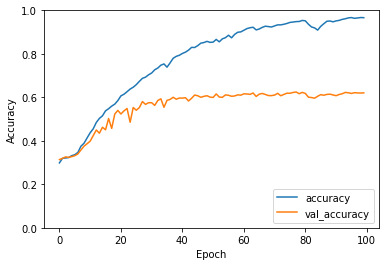

17/17 - 2s - loss: 1.8034 - accuracy: 0.6206

 Dev accuracy:  62.06 % 



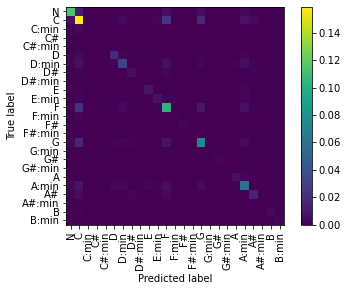

In [ ]:
#!/usr/bin/env python3
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("../input/acrisophonics/Isophonics1000_log_mel.ds")
n_samples, n_frames, n_chromas = x.shape
x = x.reshape((n_samples,n_frames,n_chromas,1))
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=0.3, random_state=args.seed)
 
# Create model
crnn_model = CRNN_1(input_shape=(n_frames, n_chromas, 1), output_classes=25)
 
# Train model
crnn_model.fit(train_x, train_y, dev_x, dev_y, epochs=100)
 
# Display score
crnn_model.display_training_progress()
print("\n","Dev accuracy: ", "{:.2f}".format(100*crnn_model.score(dev_x, dev_y)), "%", "\n")
crnn_model.display_confusion_matrix(dev_x, dev_y)

## Historical MLP progress

### Bass and Third double MLP model *(54.29%)*

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The MLP model was successfully created.
[INFO] The MLP model was successfully trained.
[INFO] The accuracy of the bass model is  59.41 %
[INFO] The accuracy of the third model is  81.75 %

 Dev accuracy:  54.29 % 

[INFO] The accuracy of the bass model is  59.41 %
[INFO] The accuracy of the third model is  81.75 %


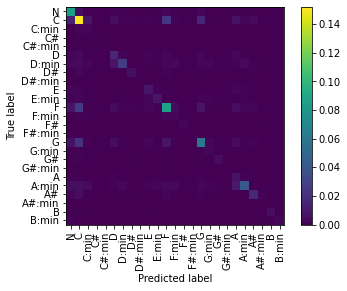

In [ ]:
#!/usr/bin/env python3

# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_22050_11008_5_flattened_mel_log_1skip.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
bass_third_model = BassVsThird(max_iter=500, random_state=7)

# Train model
bass_third_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*bass_third_model.score(dev_x, dev_y)), "%", "\n")
bass_third_model.display_confusion_matrix(dev_x, dev_y)

### MLP -> RNN model *(47,37%)*

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The MLP model with scaler preprocessing was successfully created.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 100, 128)          46080     
_________________________________________________________________
dense_4 (Dense)              (None, 100, 32)           4128      
_________________________________________________________________
dense_5 (Dense)              (None, 100, 25)           825       
Total params: 51,033
Trainable params: 51,033
Non-trainable params: 0
_________________________________________________________________
[INFO] The RNN model was successfully created.
[INFO] The acoustic model was successfully trained with dev accuracy 44.71 %


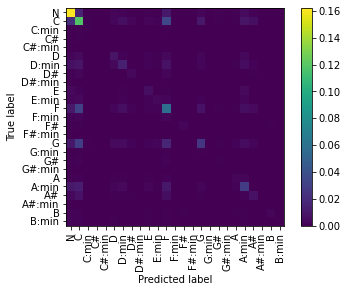

Epoch 1/35
14/14 [==============================] - 5s 145ms/step - loss: 3.1573 - accuracy: 0.1717 - val_loss: 2.8880 - val_accuracy: 0.3084
Epoch 2/35
14/14 [==============================] - 1s 80ms/step - loss: 2.7042 - accuracy: 0.2975 - val_loss: 2.2376 - val_accuracy: 0.3664
Epoch 3/35
14/14 [==============================] - 1s 80ms/step - loss: 2.2054 - accuracy: 0.3668 - val_loss: 2.0723 - val_accuracy: 0.3823
Epoch 4/35
14/14 [==============================] - 1s 79ms/step - loss: 2.1314 - accuracy: 0.3503 - val_loss: 1.9864 - val_accuracy: 0.3848
Epoch 5/35
14/14 [==============================] - 1s 77ms/step - loss: 1.9971 - accuracy: 0.3888 - val_loss: 1.9396 - val_accuracy: 0.4009
Epoch 6/35
14/14 [==============================] - 1s 78ms/step - loss: 1.9335 - accuracy: 0.4068 - val_loss: 1.9165 - val_accuracy: 0.4038
Epoch 7/35
14/14 [==============================] - 1s 78ms/step - loss: 1.9787 - accuracy: 0.3880 - val_loss: 1.8850 - val_accuracy: 0.4183
Epoch 8/35
1

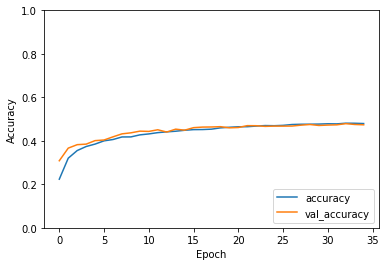

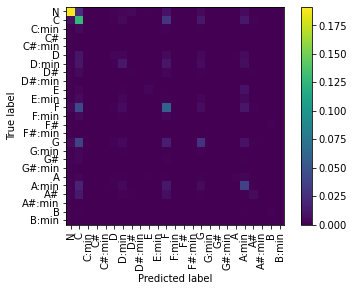

In [ ]:
#!/usr/bin/env python3
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/Isophonics100_log_mel.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=0.3, random_state=None)

# Create model
model = MLP2RNN(input_shape=x.shape, output_classes=25, max_iter=500, random_state=7)
 
# Train model and display results
model.fit(train_x, train_y, dev_x, dev_y, epochs=35)


### MEL LOG *(39.66%)* vs. CQT *(28.70%)*spectrograms 

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The MLP model with scaler preprocessing was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  39.66 % 



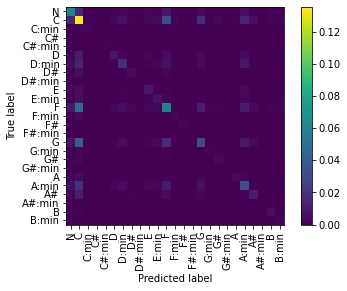

In [ ]:
#!/usr/bin/env python3

# MEL LOG spectrogram

# hop length 22050, sample rate 44100, flattened, window size 5, normalized to C major, skip 10
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./drive/MyDrive/isophonics_22050_512_5_flattened_mel_log_10skip.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP_scalered(random_state=7)

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The MLP model with scaler preprocessing was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  28.70 % 



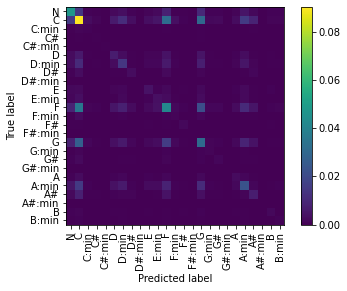

In [ ]:
#!/usr/bin/env python3

# CQT spectrogram

# hop length 22050, sample rate 44100, flattened, window size 5, normalized to C major, skip 1
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./drive/MyDrive/isophonics_22050_512_5_flattened_cqt_10skip.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP_scalered(random_state=7)

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

### Basic model, data transposed to C major key (and its modes .. dorian, phrygian, ...) - *43.12%*


[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The MLP model was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  43.12 % 



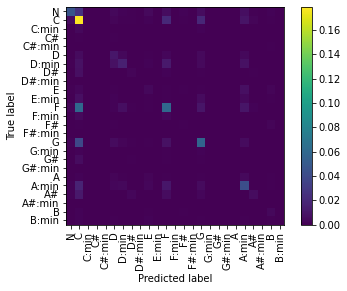

In [ ]:
#!/usr/bin/env python3

# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_5_true_500_1_true.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP(random_state=7)

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

### Basic models, all data transposed to C key - *41.97%*

[INFO] The Dataset was loaded successfully.
[INFO] The MLP model was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  41.97 % 



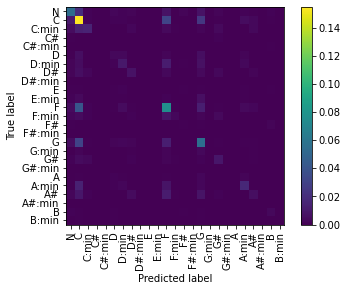

In [ ]:
#!/usr/bin/env python3

# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_5_true_500_1_true-everything_to_C.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP()

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

### Basic MLP model - *27.31%*

[INFO] The Dataset was loaded successfully.
[INFO] The MLP model was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  27.31 % 



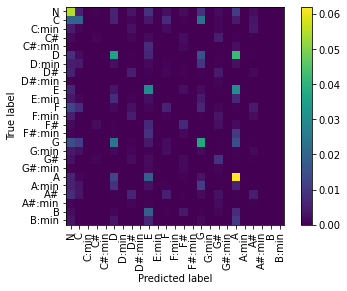

In [ ]:
#!/usr/bin/env python3

# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_5_true_500_1.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP()

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

# BILLBOARD DATASET

## CNN, RNN model, chroma NNLS features - *75.89%*

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 24, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 24, 16)       64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 24, 16)       2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 24, 16)       64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 500, 24, 16)       2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 500, 24, 16)       64        
______________________________________________________

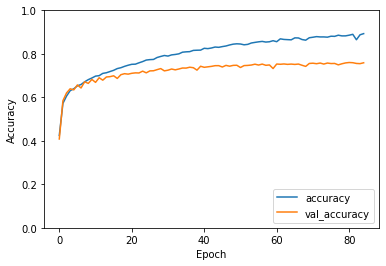

82/82 - 2s - loss: 0.9023 - accuracy: 0.7589

 Dev accuracy:  75.89 % 



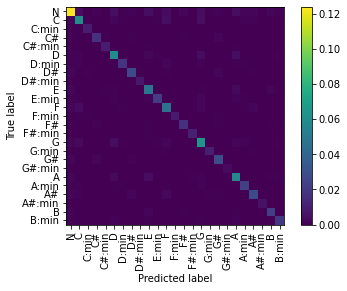

In [ ]:
#!/usr/bin/env python3
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/Billboard500.ds")
n_samples, n_frames, n_chromas = x.shape
x = x.reshape((n_samples,n_frames,n_chromas,1))
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
crnn_model = CRNN_1(input_shape=(n_frames, n_chromas, 1), output_classes=25)
 
# Train model
crnn_model.fit(train_x, train_y, dev_x, dev_y, epochs=85)

# Display score
crnn_model.display_training_progress()
print("\n","Dev accuracy: ", "{:.2f}".format(100*crnn_model.score(dev_x, dev_y)), "%", "\n")
crnn_model.display_confusion_matrix(dev_x, dev_y)